# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para Heartbeat a ser clasificado con la codificación de la ``Tendencia`` `y` LSTM

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'HeartBeat_tmp_test_data.pkl',
 'HeartBeat_tmp_train_data.pkl',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
HEARTBEAT_PATH = "data/heartbeat"

DATA_TO_SAVE = "HeartBeat"

PKL_DIR = "pkl/LSTM/Heartbeat/"
PKL_NAME = "heartbeat_LSTM_trend.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
# from utils.load_data import import_heartbeat_dataset

# train, test = import_heartbeat_dataset(HEARTBEAT_PATH)

In [4]:
# import pickle

# pickle.dump(train, open(DATA_TO_SAVE + "_tmp_train_data.pkl", 'wb'))
# pickle.dump(test, open(DATA_TO_SAVE + "_tmp_test_data.pkl", 'wb'))


In [5]:
import pickle

train = pickle.load(open(DATA_TO_SAVE + "_tmp_train_data.pkl", 'rb'))
test = pickle.load(open(DATA_TO_SAVE + "_tmp_test_data.pkl", 'rb'))


In [6]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Como ya anticipamos en el análisis en profundidad de este conjunto de datos eliminaremos todos los atributos dado su alto grado de correlación salvo los atributos: `signal_1`, `signal_10`, `signal_20`, `signal_30`, `signal_40`, `signal_50` y `signal_60`
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.

### <font color=#2451ff> Eliminación de atributos altamente correlacionados </font>

In [7]:
columns_to_remove = train.get_derived_data_columns()['attrs']
column_to_study = ['signal_1', 'signal_10', 'signal_20',
                   'signal_30', 'signal_40', 'signal_50', 'signal_60']

for col in columns_to_remove:
    if col in column_to_study:
        columns_to_remove.remove(col)

train.drop_derived_data_columns(columns_to_remove)
test.drop_derived_data_columns(columns_to_remove)


,id,TimeStamp,signal_1,signal_10,signal_20,signal_30,signal_40,signal_50,signal_60,class
0,0,0,0.004578,0.009483,0.003414,0.009437,0.008221,0.030211,1.000400,normal
1,0,1,0.011682,0.013566,0.004089,0.012686,0.012927,0.070100,0.673670,normal
2,0,2,0.017709,0.019086,0.011413,0.030151,0.039722,0.100600,0.904520,normal
3,0,3,0.016318,0.017490,0.016408,0.044615,0.059496,0.091279,1.322500,normal
4,0,4,0.011723,0.008481,0.008594,0.025718,0.030744,0.024211,1.622600,normal
...,...,...,...,...,...,...,...,...,...,...
83020,204,400,0.007057,0.001993,0.005595,0.003932,0.002723,0.002055,0.353420,abnormal
83021,204,401,0.012607,0.002142,0.004760,0.000763,0.002429,0.001636,0.349890,abnormal
83022,204,402,0.011410,0.004370,0.000505,0.000902,0.002300,0.001022,0.264820,abnormal
83023,204,403,0.008735,0.003033,0.001830,0.001835,0.004181,0.002472,0.130270,abnormal


### <font color=#2451ff> Eliminación de outliers </font>
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [8]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [9]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 204
Train: Actual number of series: 198
Test: Previous number of series: 205
Test: Actual number of series: 199


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [10]:
# Nothing to see here


# <font color=#cd0000> División en ventanas </font>
- Como concluimos en el análisis en profundidad no aplicaremos enventanado pues ya está preaplicado.

In [11]:
# Nothing to see here


# <font color=#cd0000> Codificación </font>
- Tendencia

In [12]:
from utils.codifications import temporal_trend_fn

train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])

## <font color=#cd0000> Normalización </font>

In [13]:
from utils.codifications import standardize_data

train.derived_data, test.derived_data = standardize_data(
    train.derived_data,
    test.derived_data,
    headers=train.get_derived_data_columns()['attrs']
)


## <font color=#cd0000> Tensores entrada y salida de la red </font>

In [14]:
# All lengths must be equal
series_length = train.get_shortest_serie().shape[0]
n_dims = len(train.get_derived_data_columns()['attrs'])

(
    train.get_shortest_serie().shape[0],
    train.get_largest_serie().shape[0],
    test.get_shortest_serie().shape[0],
    test.get_largest_serie().shape[0]
)


(404, 404, 404, 404)

In [15]:
import pandas as pd

# This will determine the number of series of each split
train_n_series = pd.unique(train.derived_data['id']).shape[0]
test_n_series = pd.unique(test.derived_data['id']).shape[0]

(train_n_series, test_n_series)


(198, 199)

In [16]:
X_train, _ = train.transform_derived_data_into_X_y()
X_test, _ = test.transform_derived_data_into_X_y()

y_train = train.derived_data.groupby('id').first()['class'].to_numpy()
y_test = test.derived_data.groupby('id').first()['class'].to_numpy()


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [17]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}


In [18]:
from utils.classifier_utils import apply_lstm_format
from sklearn.preprocessing import LabelEncoder

sequences_fragmenter = 1

enc = LabelEncoder()
enc.fit(y_train)

X_train, y_train = apply_lstm_format(
    X_train, y_train, train_n_series, series_length, sequences_fragmenter, enc)
X_test, y_test = apply_lstm_format(
    X_test, y_test, test_n_series, series_length, sequences_fragmenter, enc)


# <font color=#cd0000> Diseño de la topología de red </font>

In [19]:
len(train.get_derived_data_columns()['attrs'])

14

In [20]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense

nn = Sequential()

# Number of initial dimensions
nn.add(LSTM(units=56, return_sequences=True, dropout=.2, recurrent_dropout=.2))
nn.add(LSTM(units=28, dropout=.2, recurrent_dropout=.2))
# Number of Heartbeat's classes
nn.add(Dense(1, activation='sigmoid'))

## <font color=#cd0000> Compilación de la red </font>

In [21]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]

nn.compile(optimizer=RMSprop(
    learning_rate=1e-4), loss='binary_crossentropy', metrics=metrics)


## <font color=#cd0000> Visualización de resultados preliminares </font>

In [22]:
import matplotlib.pyplot as plt


def show_metrics(history):
    for metric in history.history.keys():
        if not metric.startswith('val_'):
            plt.plot(history.history[metric], label=metric)
            plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
            plt.title(metric)
            plt.ylabel('')
            plt.xlabel('Epoch')
            plt.legend(loc="upper left")
            plt.show()


## <font color=#cd0000> Entrenamiento del modelo </font>

In [ ]:
import numpy as np
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

epochs = 100

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test),
                 class_weight=class_weights,
                 verbose=1)
nn.summary()
print('\n\n')

y_pred = nn.predict(X_test)
y_pred = y_pred > .5

show_metrics(history)

## <font color=#cd0000> Clasificación </font>

In [ ]:
y_real = enc.inverse_transform(y_test)
y_pred = y_pred.astype('int')
y_pred = enc.inverse_transform(y_pred)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))


## <font color=#cd0000> Discusión de los resultados </font>
- Dimensionalidad de entrada inicial -> 14 atributos
- Vamos a estudiar diferentes rangos de hiper-parámetros que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Dado que las series son algo complejas convendría añadir algo de profundidad al modelo para adaptarlo a dicha complejidad, pero con el fin de probar diferentes arquitecturas empezaremos con una capa oculta que iremos aumentando de complejidad en función de su nº de neuronas:
    - Para un `n_units` de la dim_entrada (14) y un `learning_rate` rápido (1e-2) obtenemos resultados similares a los del mejor clasificador LSTM sobre las series en bruto y con bastante sobreajuste así que añadiremos una capa de Dropout y disminuiremos la complejidad de la red por probar una nueva combinación (aunque las series son complejas y no esperamos increíbles resultados):
   ```
   Confusion matrix:
   [[106  37]
    [ 34  22]]

   Classification report:
                  precision    recall  f1-score   support

      abnormal       0.76      0.74      0.75       143
        normal       0.37      0.39      0.38        56

      accuracy                           0.64       199
     macro avg       0.57      0.57      0.57       199
  weighted avg       0.65      0.64      0.65       199
   ```
    - Para un `n_units` de la mitad de la dim_entrada (7), un `learning_rate` rápido (1e-2) y una capa de Dropout de .2 obtenemos resultados algo peores por lo que probaremos a disminuir la tasa de aprendizaje sin aumentar la complejidad de la red ante el sobreajuste:
   ```
   Confusion matrix:
   [[97 46]
    [30 26]]

   Classification report:
                  precision    recall  f1-score   support

      abnormal       0.76      0.68      0.72       143
        normal       0.36      0.46      0.41        56

      accuracy                           0.62       199
     macro avg       0.56      0.57      0.56       199
  weighted avg       0.65      0.62      0.63       199
   ```
    - Para un `n_units` de la mitad de la dim_entrada (7), un `learning_rate` lento (1e-4) y una capa de Dropout de .2 y obtenemos resultados peores pero creemos que se debe a la reducción de la dimensionalidad la cual duplicaremos mientras bajamos a la mitad el número de épocas ante la rápida convergencia de la red:
   ```
   Confusion matrix:
   [[99 44]
    [32 24]]

   Classification report:
                  precision    recall  f1-score   support

      abnormal       0.76      0.69      0.72       143
        normal       0.35      0.43      0.39        56

      accuracy                           0.62       199
     macro avg       0.55      0.56      0.55       199
  weighted avg       0.64      0.62      0.63       199
   ```

    - Para un `n_units` del doble de la dim_entrada (28) , un `learning_rate` lento (1e-4), una capa de Dropout de .2, número de épocas a 50 y obtenemos resultados equivalentes pero que convergen antes de modo que aumentaremos la complejidad de la red con una segunda capa oculta y disminuiremos a la mitad el nº de épocas de entrenamiento:
   ```
   Confusion matrix:
   [[92 51]
    [29 27]]

   Classification report:
                  precision    recall  f1-score   support

      abnormal       0.76      0.64      0.70       143
        normal       0.35      0.48      0.40        56

      accuracy                           0.60       199
     macro avg       0.55      0.56      0.55       199
  weighted avg       0.64      0.60      0.61       199
   ```
  - Añadimos ahora dos capas ocultas, ambas con Dropout a 0.2:
    - Para un `n_units_capa1` del doble de la dim_entrada (28), `n_units_capa2` de 14, un `learning_rate` lento (1e-4) y 25 épocas obtenemos aún resultados similares que podrían mejorarde aplicar una mayor complejidad (doblaremos el nº de neuronas de todas las capas):
   ```
   Confusion matrix:
   [[93 50]
    [29 27]]

   Classification report:
                  precision    recall  f1-score   support

      abnormal       0.76      0.65      0.70       143
        normal       0.35      0.48      0.41        56

      accuracy                           0.60       199
     macro avg       0.56      0.57      0.55       199
  weighted avg       0.65      0.60      0.62       199
   ```
    - Para un `n_units_capa1` del cuádruple de la dim_entrada (56), `n_units_capa2` de 28, un `learning_rate` lento (1e-4) y 25 épocas obtenemos resultados ligeramente mejores que dejan entrever una mejoría a mayor número de épocas, algo que probaremos:
   ```
   Confusion matrix:
   [[92 51]
    [26 30]]

   Classification report:
                precision    recall  f1-score   support

      abnormal       0.78      0.64      0.70       143
        normal       0.37      0.54      0.44        56

      accuracy                           0.61       199
     macro avg       0.58      0.59      0.57       199
  weighted avg       0.66      0.61      0.63       199
   ```
    - Para un `n_units_capa1` del cuádruple de la dim_entrada (56), `n_units_capa2` de 28, un `learning_rate` lento (1e-4) y 100 épocas obtenemos resultados mejores:
   ```
   Confusion matrix:
   [[90 53]
    [15 41]]

   Classification report:
                  precision    recall  f1-score   support

      abnormal       0.86      0.63      0.73       143
        normal       0.44      0.73      0.55        56

      accuracy                           0.66       199
     macro avg       0.65      0.68      0.64       199
  weighted avg       0.74      0.66      0.68       199
   ```

## <font color=#cd0000> Conclusiones </font>
- Como podemos observar los resultados son algo mejores ya que la red mantiene información a un mayor plazo en sus memorias algo que no contemplaba un RandomForest
- Los rangos orientativos de búsqueda podrían ser:
  - `n_units_capa1`: [28, 56]
  - `n_units_capa2` fijo a 28
  - `learning_rate`: [1e-3, 8e-4, 7e-4, 5e-4, 1e-4]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con LSTM maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [23]:
N_UNITS_RANGE = range(28, 56)
LEARNING_RATE_CHOICES = [1e-3, 8e-4, 7e-4, 5e-4, 3e-4]

In [24]:
import random
import pickle
import utils.constants as cs
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop


def lstm_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        cv=5,
        lstm_dict={}):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    units_list = random.sample(
        list(N_UNITS_RANGE), n_samples)
    learning_rate_list = random.sample(
        LEARNING_RATE_CHOICES, n_samples)

    best_hyp_params = None
    best_score = 0
    for units in units_list:
        for learning_rate in learning_rate_list:
            lstm_dict[cs.LSTM_HYP_PARAM_UNITS] = units
            lstm_dict[cs.LSTM_HYP_PARAM_LEARNING_RATE] = learning_rate
            reports = windowed_cross_val(
                None,
                windowed_series,
                relation_with_series,
                cv=cv,
                seed=SEED,
                drop_columns=['class'],
                estimator_type=cs.ESTIMATOR_LSTM,
                lstm_dict=lstm_dict
            )

            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(units, learning_rate)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (units, learning_rate)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: Units={}; Learning Rate={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: Units={}; Learning Rate={}--------------"
                  .format(units, learning_rate))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [25]:
# IMPORTANTE -> ALGUNOS DE LOS PARÁMETROS DEL MODELO SON FIJADOS EN EL MÉTODO lstm_build_model del módulo
# classifier_utils.py ante problemas a la hora de clonar modelos neuronales de Keras.

# Los parámetros fijados a fuego en el código son:
#   · Una segunda capa oculta con el nº de neuronas fijas a 28
#   · Las tasas de Dropout recurrentes y de la misma capa a 0.2

lstm_dict = {
    cs.LSTM_SERIES_LENGTH: series_length,
    cs.LSTM_SEQUENCES_FRAGMENTER: 1,
    cs.LSTM_FITTED_LABELS_ENCODER: enc,
    cs.LSTM_ARGMAX_FUNCTION: None,
    cs.LSTM_N_CLASSES: 2,
    cs.LSTM_CLASS_WEIGHTS: class_weights,
    cs.LSTM_HYP_PARAM_EPOCHS: 100
}

lstm_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,c
    cv=5,
    lstm_dict=lstm_dict
)


		--------------ACTUAL BEST: Units=30; Learning Rate=0.0008--------------
Accuracy: 0.8430176755208848 +/- 0.11998840940686328
abnormal:
	precision: 0.8601667518463959 +/- 0.06604910166620122
	recall: 0.9333333333333332 +/- 0.13333333333333336
	f1-score: 0.8911712415201946 +/- 0.08846862296035443
	support: 28.2 +/- 2.7856776554368237
normal:
	precision: 0.8666666666666668 +/- 0.26666666666666666
	recall: 0.6056643356643356 +/- 0.22650201758240085
	f1-score: 0.6743892339544513 +/- 0.23309609665821418
	support: 11.4 +/- 2.4166091947189146
macro avg:
	precision: 0.8634167092565314 +/- 0.15125976175197936
	recall: 0.7694988344988345 +/- 0.14419563085896028
	f1-score: 0.782780237737323 +/- 0.15201487271626965
	support: 39.6 +/- 1.0198039027185568
weighted avg:
	precision: 0.8677903968718915 +/- 0.10012916804103775
	recall: 0.8430176755208848 +/- 0.11998840940686328
	f1-score: 0.836450754353454 +/- 0.11324702883887723
	support: 39.6 +/- 1.0198039027185568
		--------------ITERATION: Units=30;

((39, 0.0008),
 {'accuracy': (0.9949999999999999, 0.010000000000000009),
  'abnormal': {'precision': (1.0, 0.0),
   'recall': (0.993103448275862, 0.013793103448275846),
   'f1-score': (0.9964912280701753, 0.007017543859649145),
   'support': (28.2, 2.7856776554368237)},
  'normal': {'precision': (0.9833333333333332, 0.03333333333333335),
   'recall': (1.0, 0.0),
   'f1-score': (0.9913043478260869, 0.017391304347826077),
   'support': (11.4, 2.4166091947189146)},
  'macro avg': {'precision': (0.9916666666666666, 0.016666666666666698),
   'recall': (0.9965517241379309, 0.006896551724137901),
   'f1-score': (0.9938977879481312, 0.01220442410373761),
   'support': (39.6, 1.0198039027185568)},
  'weighted avg': {'precision': (0.9954166666666666, 0.009166666666666724),
   'recall': (0.9949999999999999, 0.010000000000000009),
   'f1-score': (0.9950648360030512, 0.00987032799389782),
   'support': (39.6, 1.0198039027185568)}})

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- En este caso ejecutaremos CV dado que tenemos suficientes series

In [ ]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``n_units`` = 39 y ``learning_rate`` = 0.0008:
    ```
        Accuracy: 0.9949999999999999 +/- 0.010000000000000009
        abnormal:
            precision: 1.0 +/- 0.0
            recall: 0.993103448275862 +/- 0.013793103448275846
            f1-score: 0.9964912280701753 +/- 0.007017543859649145
            support: 28.2 +/- 2.7856776554368237
        normal:
            precision: 0.9833333333333332 +/- 0.03333333333333335
            recall: 1.0 +/- 0.0
            f1-score: 0.9913043478260869 +/- 0.017391304347826077
            support: 11.4 +/- 2.4166091947189146
        macro avg:
            precision: 0.9916666666666666 +/- 0.016666666666666698
            recall: 0.9965517241379309 +/- 0.006896551724137901
            f1-score: 0.9938977879481312 +/- 0.01220442410373761
            support: 39.6 +/- 1.0198039027185568
        weighted avg:
            precision: 0.9954166666666666 +/- 0.009166666666666724
            recall: 0.9949999999999999 +/- 0.010000000000000009
            f1-score: 0.9950648360030512 +/- 0.00987032799389782
            support: 39.6 +/- 1.0198039027185568
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [26]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


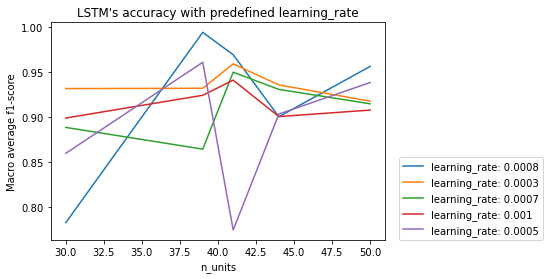

In [27]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


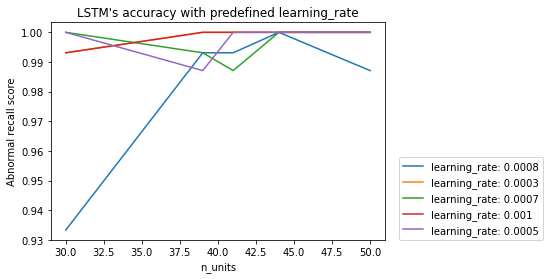

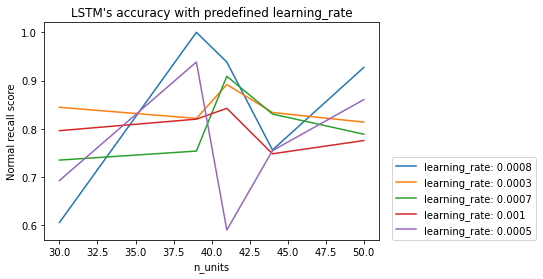

In [28]:
abnormal_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['abnormal']['recall'][0],
                   'std': all_reports[z]['abnormal']['recall'][1]}),
    all_reports
))

normal_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['normal']['recall'][0],
                   'std': all_reports[z]['normal']['recall'][1]}),
    all_reports
))

plot_score(
    [abnormal_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Abnormal recall score'
)

plot_score(
    [normal_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Normal recall score'
)


## <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

### <font color=#cd0000> Construcción del modelo </font>

In [29]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense

nn = Sequential()

# Number of initial dimensions
nn.add(LSTM(units=39, return_sequences=True, dropout=.2, recurrent_dropout=.2))
nn.add(LSTM(units=28, dropout=.2, recurrent_dropout=.2))
# Number of Heartbeat's classes
nn.add(Dense(1, activation='sigmoid'))

In [30]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]

nn.compile(optimizer=RMSprop(
    learning_rate=0.0008), loss='binary_crossentropy', metrics=metrics)


### <font color=#cd0000> Entrenamiento </font>

Epoch 1/100
7/7 [==============================] - 4s 624ms/step - loss: 0.6472 - ACC: 1.0000 - Prec: 0.4333 - Rec: 0.4561 - AUC: 0.6700 - val_loss: 0.6004 - val_ACC: 1.0000 - val_Prec: 0.4194 - val_Rec: 0.2321 - val_AUC: 0.6069
Epoch 2/100
7/7 [==============================] - 3s 426ms/step - loss: 0.5554 - ACC: 1.0000 - Prec: 0.5556 - Rec: 0.3509 - AUC: 0.6986 - val_loss: 0.5695 - val_ACC: 1.0000 - val_Prec: 0.4783 - val_Rec: 0.1964 - val_AUC: 0.6525
Epoch 3/100
7/7 [==============================] - 3s 421ms/step - loss: 0.5257 - ACC: 1.0000 - Prec: 0.6129 - Rec: 0.3333 - AUC: 0.7451 - val_loss: 0.5584 - val_ACC: 1.0000 - val_Prec: 0.4231 - val_Rec: 0.1964 - val_AUC: 0.6807
Epoch 4/100
7/7 [==============================] - 3s 404ms/step - loss: 0.5100 - ACC: 1.0000 - Prec: 0.6250 - Rec: 0.3509 - AUC: 0.7684 - val_loss: 0.5413 - val_ACC: 1.0000 - val_Prec: 0.5200 - val_Rec: 0.2321 - val_AUC: 0.7117
Epoch 5/100
7/7 [==============================] - 3s 403ms/step - loss: 0.5018 - AC

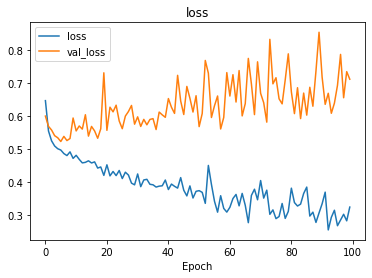

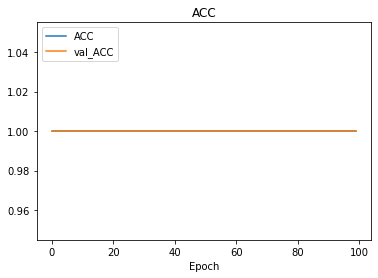

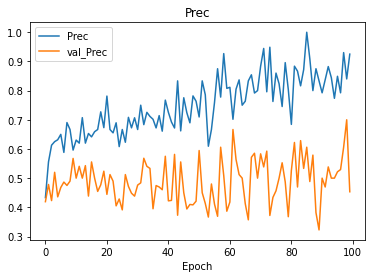

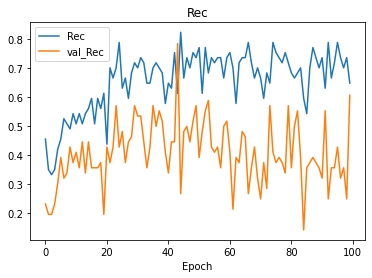

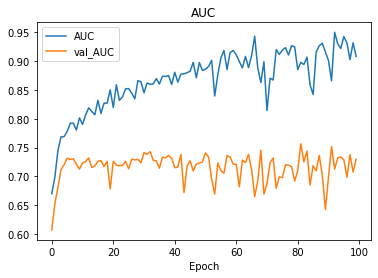

In [31]:
import numpy as np
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

epochs = 100

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test))
nn.summary()
print('\n\n')

y_pred = nn.predict(X_test)
y_pred = y_pred > .5

show_metrics(history)

### <font color=#cd0000> Clasificación </font>

In [32]:
y_real = enc.inverse_transform(y_test)
y_pred = y_pred.astype('int')
y_pred = enc.inverse_transform(y_pred)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[102  41]
 [ 22  34]]
              precision    recall  f1-score   support

    abnormal       0.82      0.71      0.76       143
      normal       0.45      0.61      0.52        56

    accuracy                           0.68       199
   macro avg       0.64      0.66      0.64       199
weighted avg       0.72      0.68      0.70       199



c:\Users\Javier\anaconda3\envs\tfg_env\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# <font color=#cd0000> Conclusiones </font>
- Por lo que podemos observar obtenemos resultados ligeramente mejores a los de clasificar las series en bruto.